In [1]:
import sys
from pathlib import Path

import h5py as h5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from natsort import natsorted

sys.path.append('../lib')
from local_paths import mplstyle_path, analysis_dir, database_dir
from stats_utils import fdr_correction
from summary_utils import verified_update, annotate_unit_df

In [2]:
plt.style.use(mplstyle_path)

# Parameters

In [3]:
analysis_name = 'rsc_1pt'
results_dir = analysis_dir + analysis_name

# selection criteria
min_sc = 0.1
fdr_level = 0.01

# plotting
max_scatter = 5000

# saved unit selection (to check against)
vsel_path = database_dir + 'unit_sel/visually_selective.csv.gz'
fsel_path = database_dir + 'unit_sel/fixation_selective.csv.gz'

# Load data

In [4]:
results_dir = Path(results_dir).expanduser()
vsel_path = Path(vsel_path)
fsel_path = Path(fsel_path)

In [5]:
def set_coords(coords, k, v):
    try:
        assert np.array_equal(coords[k], v)
    except KeyError:
        coords[k] = v

In [6]:
unit_df = {'Session': [], 'Unit': []}
results = {k: [] for k in ('rsc', 'pvals_1', 'pvals_2', 'diff_2', 'sc_0', 'sc_1')}

for fp in natsorted(results_dir.glob('*.h5')):
    # natsorted, together with random subsampling for scatter plot below,
    # makes sure the plotted dots are reproducible
    with h5.File(fp, 'r') as f:
        try:
            assert f[f'progress_report/{analysis_name}/all_done'][()]
        except (KeyError, AssertionError):
            continue

    dset1 = xr.load_dataset(fp, group='rsc_1pt/current', engine='h5netcdf')
    dset2 = xr.load_dataset(fp, group='rsc_1pt/permutation_test/current_v_same_image', engine='h5netcdf')

    coords_ = {}
    for dset in (dset1, dset2):
        verified_update(coords_, dict(unit=dset.coords['unit'].astype(str)))

    pvals_1 = dset1['p-value'].values[0]
    rsc = dset1['sample'].values
    pvals_2 = dset2['p-value'].values[0]
    diff_2 = dset2['diff'].values
    sc_0 = dset2['cond0'].values
    sc_1 = dset2['cond1'].values

    results['rsc'].append(rsc)
    results['pvals_1'].append(pvals_1)
    results['pvals_2'].append(pvals_2)
    results['diff_2'].append(diff_2)
    results['sc_0'].append(sc_0)
    results['sc_1'].append(sc_1)

    unit_names = coords_['unit']
    unit_df['Session'].append(np.full(unit_names.size, fp.stem))
    unit_df['Unit'].append(unit_names)

print('results:')
for d in (results, unit_df):
    for k, v in d.items():
        d[k] = v = np.concatenate(v, axis=-1)
        print('\t', f'{k:<20s}', v.shape, '\t', v.dtype)
print(np.unique(unit_df['Session']).size, 'sessions')
unit_df = annotate_unit_df(pd.DataFrame(unit_df))

results:
	 rsc                  (66681,) 	 float32
	 pvals_1              (66681,) 	 float64
	 pvals_2              (66681,) 	 float64
	 diff_2               (66681,) 	 float32
	 sc_0                 (66681,) 	 float32
	 sc_1                 (66681,) 	 float32
	 Session              (66681,) 	 <U10
	 Unit                 (66681,) 	 <U4
678 sessions


# Select units

In [7]:
for i in range(1,3):
    results[f'arej_{i}'], results[f'apvals_{i}'] = (v[None] for v in fdr_correction({None: results[f'pvals_{i}']}, q=fdr_level))

In [8]:
n_tot = len(unit_df)
mval = np.isfinite(results['apvals_1']) & np.isfinite(results['apvals_2']) & np.isfinite(results['rsc'])

# visually selective
mvs = mval & results['arej_1'] & (results['rsc'] >= min_sc)

# fixation-selective
mfs = mvs & results['arej_2']

In [9]:
print('Total:\t\t\t', n_tot)
print('With valid results:\t', mval.sum())
print('Visually selective:\t', mvs.sum(), f'({mvs.sum()/mval.sum()*100:.1f}%; RSC >= {min_sc}, q < {fdr_level} for RSC > 0)')
print()

for case, m in (
        ('all vis. selective', mvs),
        ('sig. fix. selective', mfs),
        ('not sig. fix. selective', mvs&~results['arej_2'])):

    ma = results['diff_2'][m] < 0
    fa = ma.mean() * 100
    na = ma.sum()
    mb = results['diff_2'][m] >= 0
    fb = mb.mean() * 100
    nb = mb.sum()

    print(case)
    print(f'\t{m.sum()/mvs.sum()*100:5.1f}% (n = {m.sum():5d}) | '
          f'curr > ctrl: {fa:5.1f}% ({na:>5d}|{na/mvs.sum()*100:4.1f}%) | '
          f'curr <= ctrl: {fb:4.1f}% ({nb:>4d}|{nb/mvs.sum()*100:4.1f}%)')

Total:			 66681
With valid results:	 66260
Visually selective:	 26975 (40.7%; RSC >= 0.1, q < 0.01 for RSC > 0)

all vis. selective
	100.0% (n = 26975) | curr > ctrl:  95.7% (25810|95.7%) | curr <= ctrl:  4.3% (1165| 4.3%)
sig. fix. selective
	 60.7% (n = 16372) | curr > ctrl: 100.0% (16372|60.7%) | curr <= ctrl:  0.0% (   0| 0.0%)
not sig. fix. selective
	 39.3% (n = 10603) | curr > ctrl:  89.0% ( 9438|35.0%) | curr <= ctrl: 11.0% (1165| 4.3%)


Check unit selection

In [10]:
for sel_path, msel in ((fsel_path, mfs), (vsel_path, mvs)):
    sel_idc0 = pd.MultiIndex.from_frame(pd.read_csv(sel_path)[['Session', 'Unit']])
    sel_idc = pd.MultiIndex.from_frame(unit_df.loc[msel].reset_index()[['Session','Unit']])
    assert sel_idc0.isin(sel_idc).all()
    assert sel_idc.isin(sel_idc0).all()

Save units for which ctrl > curr

In [11]:
mb = mvs & (results['diff_2'] >= 0)
print(mb.sum())
unit_df[mb].to_csv('unit_sel/curr_lt_ctrl.csv.gz', index=False)

1165


# Make plots

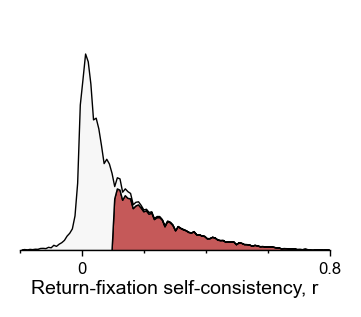

In [12]:
xlim = (-.2, .8)
data = pd.DataFrame({'rsc': results['rsc'], 'Significant': mvs})
m = (data['rsc'] >= xlim[0]) & (data['rsc'] < xlim[1])
data = data.loc[m]

plt.figure(figsize=(2,1.5))
ax = plt.gca()

sns.histplot(
    data=data, x='rsc', hue='Significant',
    multiple='stack', element='poly', stat='density',
    hue_order=(False,True), palette={False:'whitesmoke',True:'firebrick'},
    legend=False, lw=0.5)

xbound = xlim
xtks = (0,.8)
ax.set_xlim(xbound)
ax.set_xticks(xtks, list(map(str, xtks)))
ax.set_xticks(np.arange(*xbound,.2), minor=True)
ax.spines['bottom'].set_bounds(xbound)
ax.set_xlabel('Return-fixation self-consistency, r')

ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.set_ylabel('')

plt.savefig('plots/fig3b.png')

In [13]:
data = pd.DataFrame({'sc_0': results['sc_0'][mvs], 'sc_1': results['sc_1'][mvs], 'Significant': mfs[mvs]})
print(data.shape)
data[['sc_0', 'sc_1']].describe()

(26975, 3)


,sc_0,sc_1
count,26975.000000,26975.000000
mean,0.259770,0.130910
std,0.136956,0.097277
min,-0.002769,-0.048964
25%,0.153317,0.066115
50%,0.223011,0.106575
75%,0.333023,0.168112
max,1.000000,0.951821


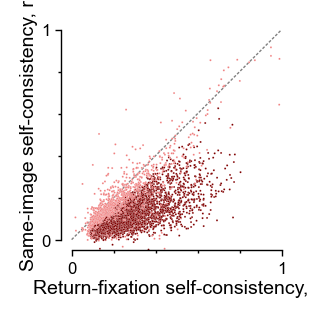

In [14]:
sel = np.unique(np.round(np.linspace(0, 1, max_scatter) * (len(data)-1)).astype(int))

plt.figure(figsize=(1.5,1.5))
ax = plt.gca()

sns.scatterplot(
    data=data.iloc[sel], x='sc_0', y='sc_1', hue='Significant',
    hue_order=(False,True), palette={False:'lightcoral',True:'maroon'},
    s=.5, legend=False)
ax.plot([0,1], [0,1], c='gray', ls='--', lw=0.5, zorder=-1)

ax.set_xlim(-.05, 1.05)
ax.set_xticks([0, 1])
ax.set_xticks(np.arange(0,1,.2), minor=True)
ax.spines['bottom'].set_bounds([0, 1])
ax.set_xlabel('Return-fixation self-consistency, r')

ax.set_ylim(-.05, 1.05)
ax.set_yticks([0, 1])
ax.set_yticks(np.arange(0,1,.2), minor=True)
ax.spines['left'].set_bounds([0, 1])
ax.set_ylabel('Same-image self-consistency, r')

ax.set_aspect('equal')

plt.savefig('plots/fig3c.png')